## This Notebook gives an example on how plot estimated CAG expansion and Aggregate correlation in single cells (Figure 5 and Supplementary Figure 13 in the manuscript)

In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats

In [2]:
adata=sc.read_h5ad('../adata_0803_0908_f_AGG_orig.h5ad')

In [3]:
#Estimated Mean CAG

adata.obs['CAG_length'] = [
    (cag_level - 0.0464) / 0.0024 if batch == 'Aug' else (cag_level - 0.0462) / 0.003
    for cag_level, batch in zip(adata.obs['CAG'], adata.obs['batch'])
]

In [4]:
wt_allele = {
    "C1": 30, "C3": 19, "C4": 19, "C5": 17,
    "H1": 22, "H2": 20, "H3": 19, "H4": 20, "H5": 19
}

In [5]:
#Estimated Mutant CAG

for pt in adata.obs['patient'].unique():
    if pt in wt_allele:
        mask = adata.obs['patient'] == pt
        adata.obs.loc[mask, "CAG_mut"] = (
            adata.obs.loc[mask, "CAG_length"] * 2 - wt_allele[pt]
        )

In [6]:
##################################################
#### FIGURE 5B: Percent of cells with Aggregates and/or CAG expansion >140
##################################################

In [7]:
adata.obs['Expansion'] = adata.obs['CAG_mut'] >= 150
adata.obs['Expansion'] = adata.obs['Expansion'].apply(lambda x: True if x else False)

In [8]:
HTT_5 = adata[adata.obs['nHTT'] > 5]
Neuron_HD = HTT_5[(HTT_5.obs['cluster_general'].isin(['Excitatory Neurons', 'Inhibitory Neurons'])) & 
    (HTT_5.obs['HD']==True)].copy()

In [9]:
cluster_order = [ "L2.IT", "L3.IT","L4.IT",'L5.IT', 'L5.ET', "L5.6.NP",'L6.IT', 'L6.Car3', "L6.CT",'L6b',"Chandelier","LAMP5","PVALB", "SNCG",'VIP', "SST" ]

/var/folders/7p/t1dymgvj689ffh7fbygsmbzc0000gp/T/ipykernel_51067/1742601868.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  condition_counts = data_df.groupby(['cluster_names', 'Condition']).size().unstack(fill_value=0)


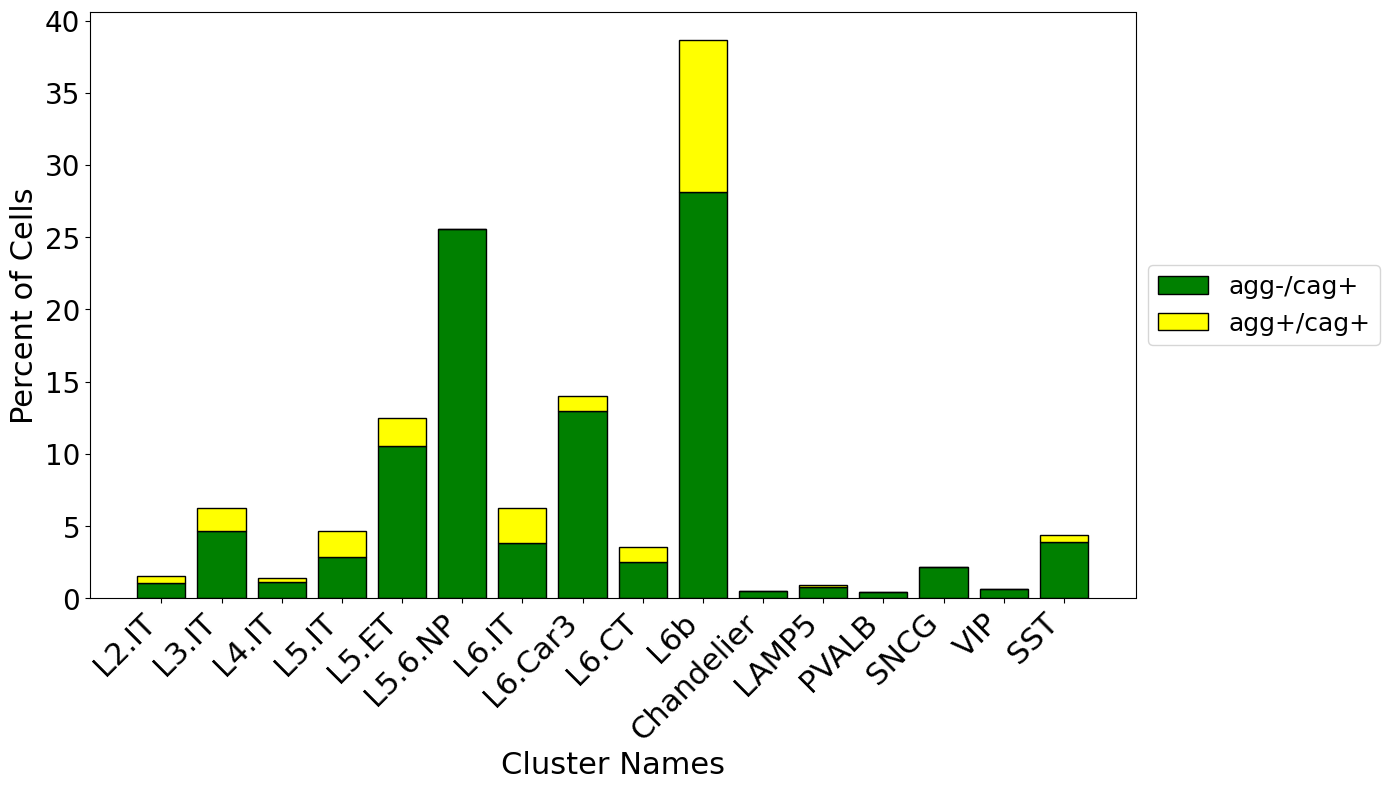

In [10]:
data_df = Neuron_HD.obs[['Agg', 'Expansion', 'cluster_names','patient','CAG_length']].copy()

data_df['Agg'] = data_df['Agg'].fillna(False).astype('bool')
data_df['Expansion'] = pd.to_numeric(data_df['Expansion'], errors='coerce')
data_df['Expansion'] = data_df['Expansion'].fillna(False)

# Create categories for the four conditions
data_df['Condition'] = 'agg-/cag-'  # Default
data_df.loc[(data_df['Agg']) & (data_df['Expansion']), 'Condition'] = 'agg+/cag+'
data_df.loc[(data_df['Agg']) & (~data_df['Expansion']), 'Condition'] = 'agg+/cag-'
data_df.loc[(~data_df['Agg']) & (data_df['Expansion']), 'Condition'] = 'agg-/cag+'

# Calculate the percentages for each cluster and condition
condition_counts = data_df.groupby(['cluster_names', 'Condition']).size().unstack(fill_value=0)
total_counts = condition_counts.sum(axis=1)
percentages = (condition_counts.T / total_counts).T * 100

# Define bar positions and width
percentages = percentages.loc[cluster_order]
clusters = percentages.index
conditions = [ 'agg-/cag+','agg+/cag+']  # Reverse order for plotting
bar_width = 0.8
index = np.arange(len(clusters))


# Colors for each condition
colors = {
    'agg-/cag-': 'grey',
    'agg+/cag-': 'magenta',
    'agg-/cag+': 'green',
    'agg+/cag+': 'yellow'
}

# Plotting
plt.figure(figsize=(14, 8))

# Stacked bar plot
bottoms = np.zeros(len(clusters))
for condition in conditions:
    plt.bar(index, percentages[condition], bar_width, bottom=bottoms, label=condition, color=colors[condition], edgecolor='black')
    bottoms += percentages[condition]

# Formatting
plt.title('', fontsize=25)
plt.xlabel('Cluster Names', fontsize=22)
plt.ylabel('Percent of Cells', fontsize=22)
plt.xticks(index, clusters, fontsize=22, rotation=45, ha='right')
plt.yticks(fontsize=20)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18)

# Adjust layout to fit labels
plt.tight_layout()
plt.show()


In [11]:
##################################################
#### FIGURE 5C: CAG length in Excitatory Neurons with Intranuclear Aggregates
##################################################

In [12]:
HD_Exc = HTT_5[(HTT_5.obs['cluster_general']=='Excitatory Neurons') & 
    (HTT_5.obs['HD']==True)].copy()

/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


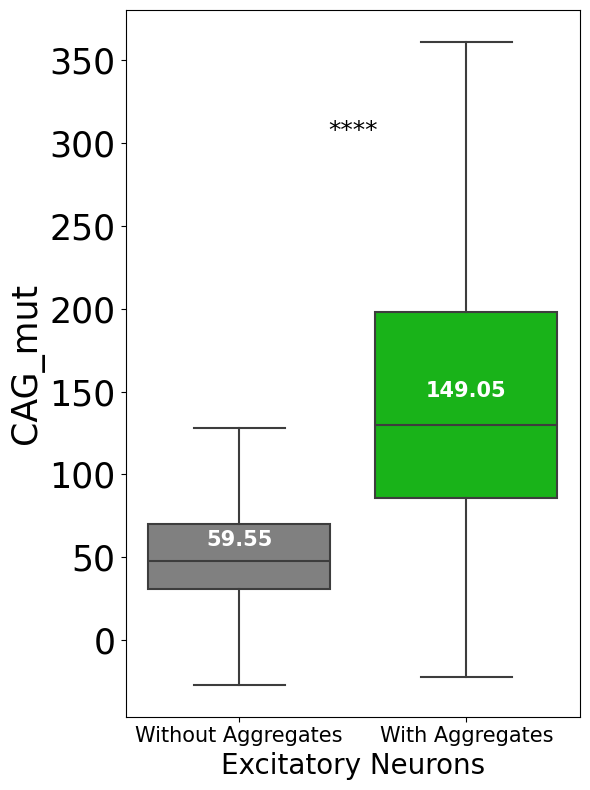

In [13]:
data_df = HD_Exc.obs[['Agg','CAG_mut' ,'nHTT','cluster_names','total_counts']].copy()
agg_mask = data_df['Agg'] == True
with_agg = data_df[agg_mask]['CAG_mut']
without_agg = data_df[~agg_mask]['CAG_mut']


t_stat, p_val = stats.ttest_ind(with_agg, without_agg, equal_var=False, nan_policy='omit')

plot_df = pd.DataFrame({
    'CAG_mut': np.concatenate([without_agg, with_agg]),
    'Aggregation': ['Without Aggregates'] * len(without_agg) + ['With Aggregates'] * len(with_agg)
})

plt.figure(figsize=(6, 8))
ax = sns.boxplot(x='Aggregation', y='CAG_mut', data=plot_df, order=['Without Aggregates', 'With Aggregates'], palette=['grey','#00cc00'], showfliers=False)

agg_means = plot_df.groupby('Aggregation')['CAG_mut'].mean()
agg_sems = plot_df.groupby('Aggregation')['CAG_mut'].sem()


positions = {'Without Aggregates': 0, 'With Aggregates': 1}  # Dictionary to map aggregation status to plot positions

for status, position in positions.items():
    mean = agg_means[status]
    sem = agg_sems[status]
    plt.text(position, mean-5, f'{mean:.2f}', ha='center', va='bottom', fontsize=15, color='white', weight='bold')


if p_val < 0.05:
    significance = '*'
    if p_val < 0.01:
        significance = '**'
    if p_val < 0.001:
        significance = '***'
    if p_val < 0.0001:
        significance = '****'
    plt.text(0.5, 300, significance, ha='center', va='bottom', fontsize=18)

plt.xlabel('Excitatory Neurons', fontsize=20)
plt.ylabel('CAG_mut', fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=25)

plt.tight_layout()

plt.show()


In [14]:
##################################################
#### SUPPLEMENTARY FIGURE 13A: CAG length in Excitatory Neurons with Intranuclear Aggregates by donor
##################################################

In [15]:
upatientHD=HD_Exc.obs['patient'].unique()

/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


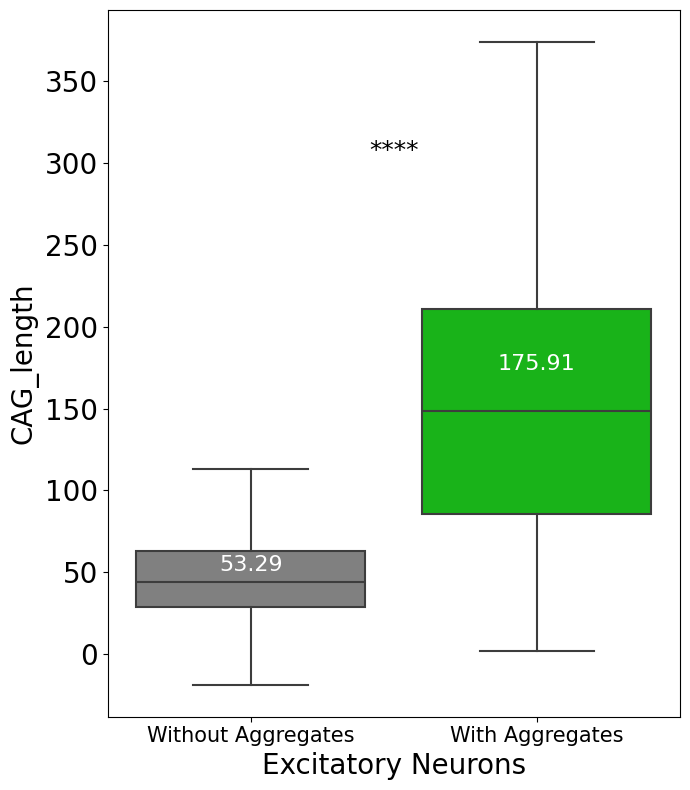

H1


/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


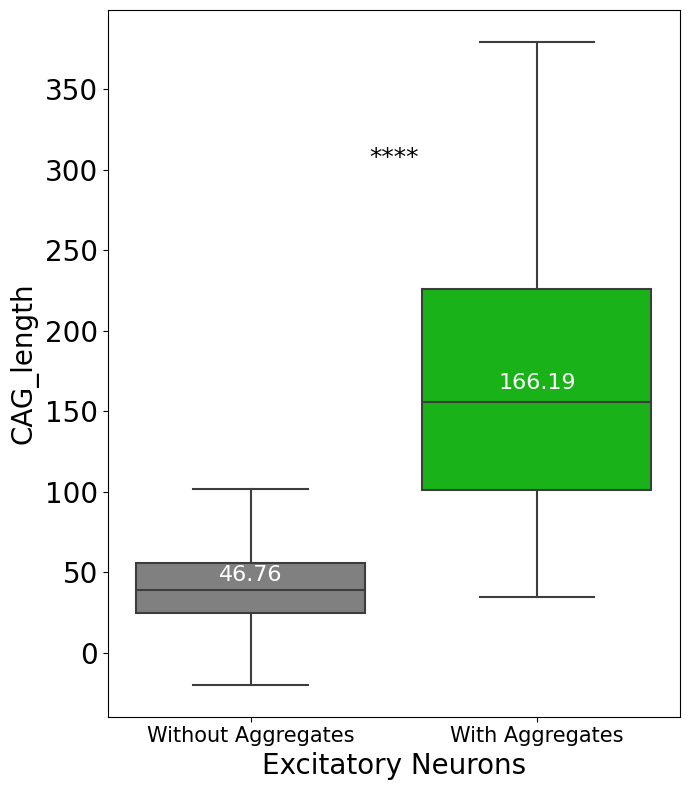

/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


H2


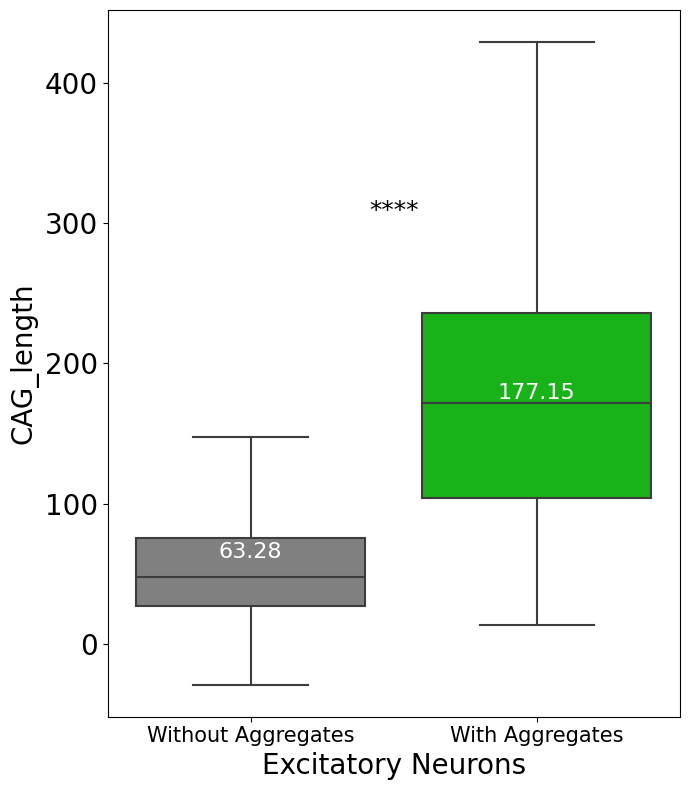

H4


/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


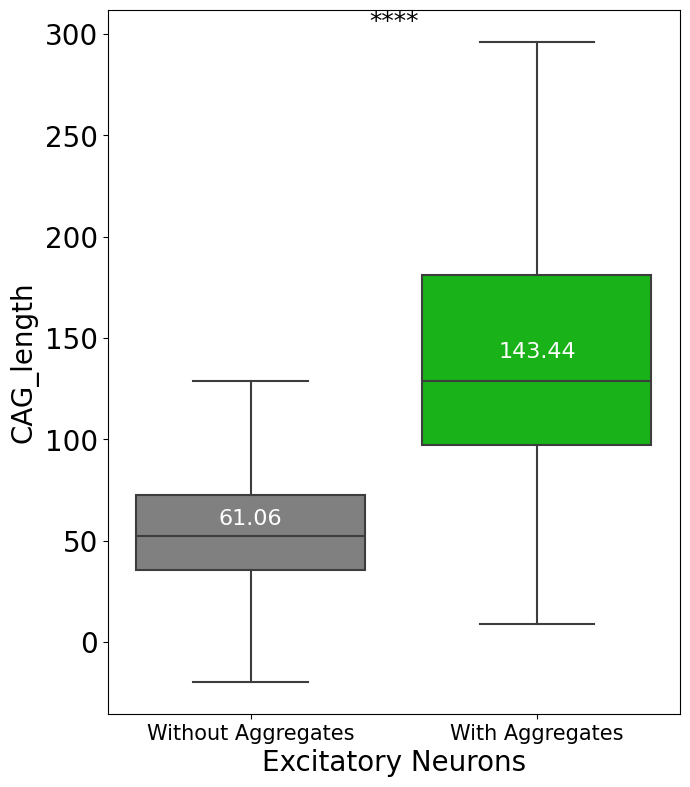

H3


/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Olatz/anaconda3/envs/napari/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


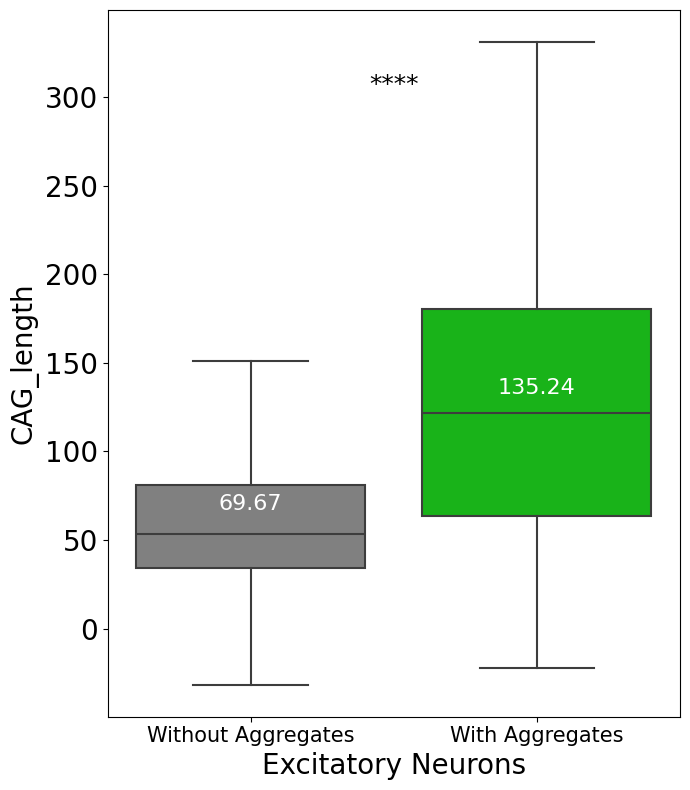

H5


In [16]:
for pt in upatientHD:
    sorted_df = HD_Exc.obs[['patient','Agg','CAG_mut' ,'nHTT','cluster_names','total_counts']].copy()
    data_df = sorted_df[sorted_df['patient']==pt].copy()
    agg_mask = data_df['Agg'] == True
    with_agg = data_df[agg_mask]['CAG_mut']
    without_agg = data_df[~agg_mask]['CAG_mut']
    
    
    t_stat, p_val = stats.ttest_ind(with_agg, without_agg, equal_var=False, nan_policy='omit')
    
    plot_df = pd.DataFrame({
        'CAG_mut': np.concatenate([without_agg, with_agg]),
        'Aggregation': ['Without Aggregates'] * len(without_agg) + ['With Aggregates'] * len(with_agg)
    })
    
    
    plt.figure(figsize=(7, 8))
    ax = sns.boxplot(x='Aggregation', y='CAG_mut', data=plot_df, order=['Without Aggregates', 'With Aggregates'], palette=['grey','#00cc00'], showfliers=False)
    
    # Calculate means and SEMs
    agg_means = plot_df.groupby('Aggregation')['CAG_mut'].mean()
    agg_sems = plot_df.groupby('Aggregation')['CAG_mut'].sem()
    
    
    positions = {'Without Aggregates': 0, 'With Aggregates': 1}  # Dictionary to map aggregation status to plot positions
    
    for status, position in positions.items():
        mean = agg_means[status]
        sem = agg_sems[status]
        #plt.errorbar(position, mean, yerr=sem, fmt='none', c='black', capsize=5)
        plt.text(position, mean-5, f'{mean:.2f}', ha='center', va='bottom', fontsize=16, color='white')
    
    if p_val < 0.05:
        significance = '*'
        if p_val < 0.01:
            significance = '**'
        if p_val < 0.001:
            significance = '***'
        if p_val < 0.0001:
            significance = '****'
        plt.text(0.5, 300, significance, ha='center', va='bottom', fontsize=18)
    
    plt.xlabel('Excitatory Neurons', fontsize=20)
    plt.ylabel('CAG_length', fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=20)
    
    plt.tight_layout()
    
    plt.show()
    print(pt)


In [17]:
##################################################
#### FIGURE 5D: Intranuclear Aggregates and CAG Expansion
##################################################

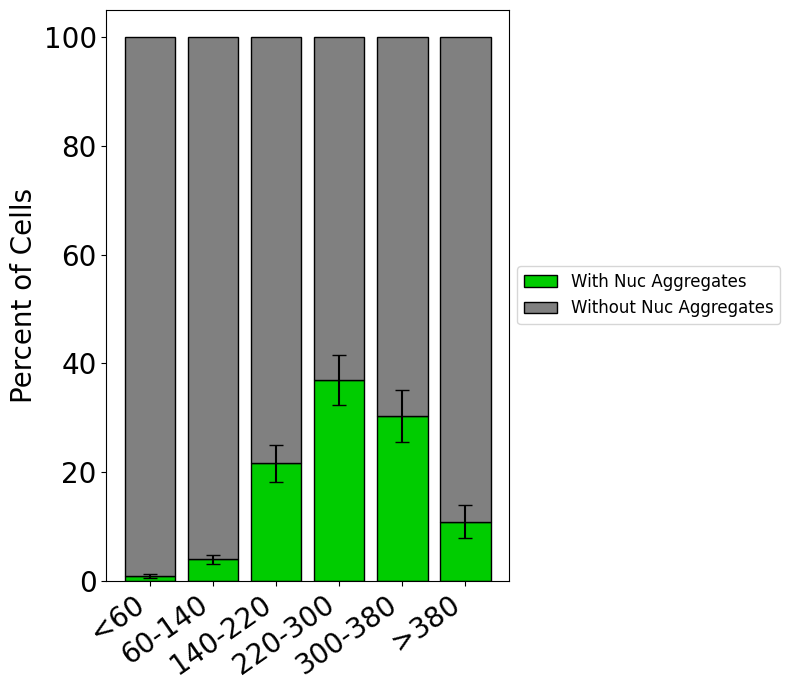

In [18]:
bins = [0, 60, 140, 220, 300, 380, np.inf]
bin_labels = ['<60', '60-140', '140-220', '220-300', '300-380', '>380']

agg_percent_matrix = []

for pt in upatientHD:
    sorted_df = HD_Exc.obs[['CAG_mut', 'Agg', 'patient']].copy()
    data_df = sorted_df[sorted_df['patient'] == pt].copy()

    data_df['Agg'] = data_df['Agg'].fillna(False).astype(bool)
    data_df['CAG_mut'] = pd.to_numeric(data_df['CAG_mut'], errors='coerce')
    data_df = data_df.dropna(subset=['CAG_mut'])

    ncells, _ = np.histogram(data_df['CAG_mut'], bins=bins)
    ncells_AGG, _ = np.histogram(data_df.loc[data_df['Agg'], 'CAG_mut'], bins=bins)

    with np.errstate(divide='ignore', invalid='ignore'):
        percent_cells_with_agg = 100 * (ncells_AGG / ncells)
        percent_cells_with_agg = np.nan_to_num(percent_cells_with_agg)

    agg_percent_matrix.append(percent_cells_with_agg)

# Convert to DataFrame
agg_df = pd.DataFrame(agg_percent_matrix, columns=bin_labels, index=upatientHD)

# Compute mean and SEM
mean_with_agg = agg_df.mean()
sem_with_agg = agg_df.sem()

mean_without_agg = 100 - mean_with_agg
sem_without_agg = agg_df.apply(lambda col: np.sqrt((col.std(ddof=1) ** 2) + (col.std(ddof=1) ** 2)) / np.sqrt(len(col)), axis=0)

# Plot
plt.figure(figsize=(8, 7))
x = np.arange(len(bin_labels))
bar_width = 0.6

# With aggregates
plt.bar(x, mean_with_agg, yerr=sem_with_agg, capsize=5, label='With Nuc Aggregates',
        color='#00cc00', edgecolor='black')

# Without aggregates (stacked below)
plt.bar(x, mean_without_agg, bottom=mean_with_agg, label='Without Nuc Aggregates',
        color='grey', edgecolor='black')

# Formatting
plt.xticks(x, bin_labels, fontsize=20, rotation=35, ha='right')
plt.yticks(fontsize=20)
plt.ylabel('Percent of Cells', fontsize=20)
plt.title('', fontsize=20)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
#plt.legend(fontsize=20)
plt.tight_layout()
plt.show()


In [19]:
##################################################
#### SUPPLEMENTARY FIGURE 13B: Intranuclear Aggregates and CAG Expansion by donor
##################################################

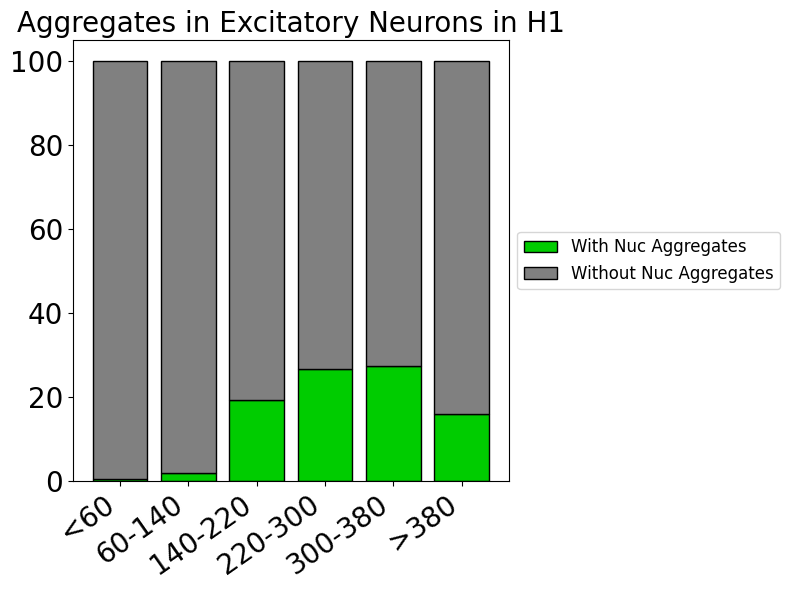

[2074  734   73   15   11   19]
[ 7 13 14  4  3  3]
[ 0.33751205  1.77111717 19.17808219 26.66666667 27.27272727 15.78947368]
[99.66248795 98.22888283 80.82191781 73.33333333 72.72727273 84.21052632]


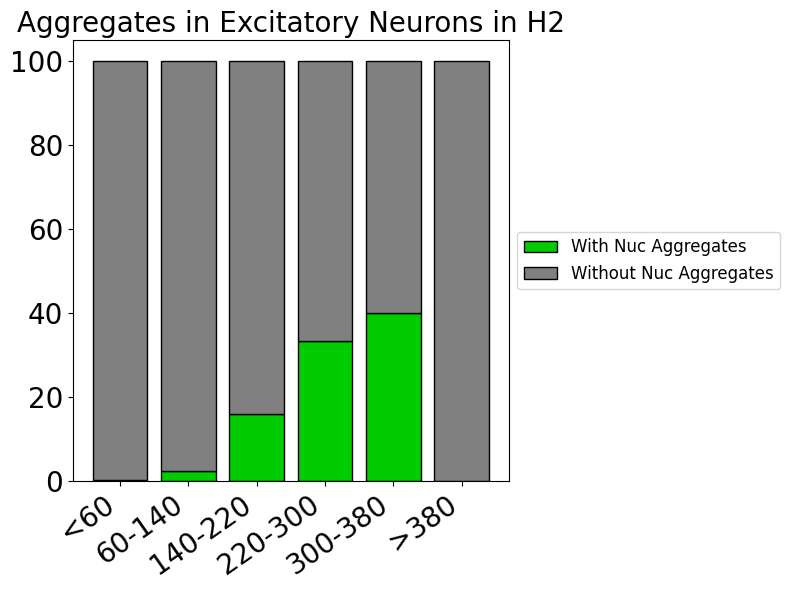

[1199  291   38   12    5    8]
[3 7 6 4 2 0]
[ 0.25020851  2.40549828 15.78947368 33.33333333 40.          0.        ]
[ 99.74979149  97.59450172  84.21052632  66.66666667  60.
 100.        ]


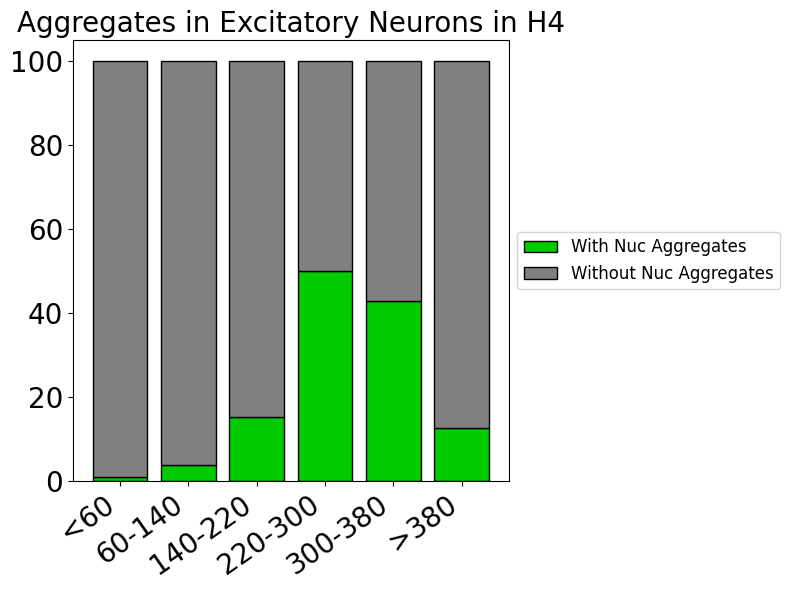

[800 452  66  28   7  16]
[ 6 17 10 14  3  2]
[ 0.75        3.76106195 15.15151515 50.         42.85714286 12.5       ]
[99.25       96.23893805 84.84848485 50.         57.14285714 87.5       ]


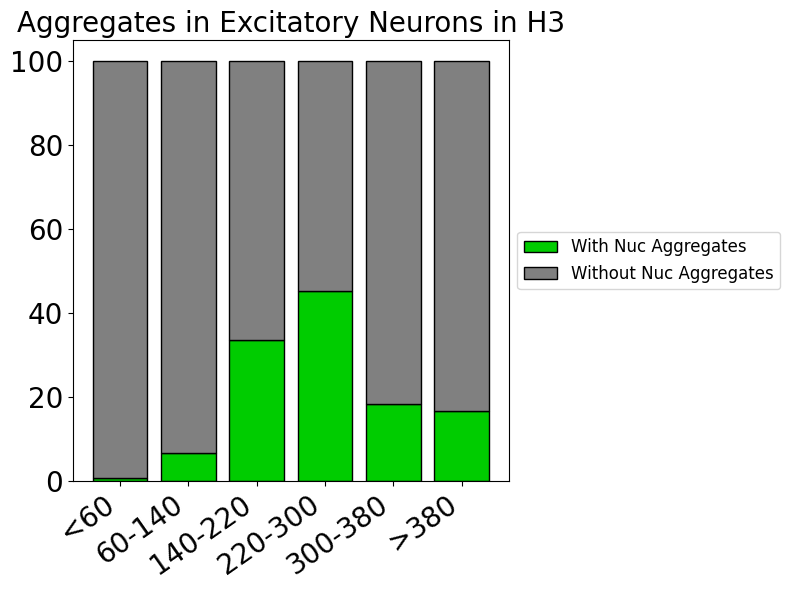

[2184 1408  146   42   11   18]
[14 92 49 19  2  3]
[ 0.64102564  6.53409091 33.56164384 45.23809524 18.18181818 16.66666667]
[99.35897436 93.46590909 66.43835616 54.76190476 81.81818182 83.33333333]


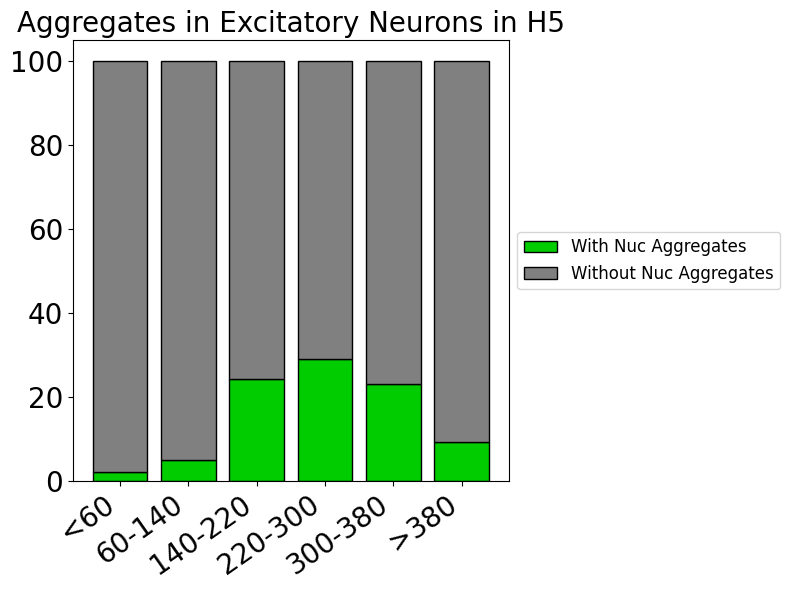

[1535 1009  170   45   13   33]
[32 50 41 13  3  3]
[ 2.08469055  4.95540139 24.11764706 28.88888889 23.07692308  9.09090909]
[97.91530945 95.04459861 75.88235294 71.11111111 76.92307692 90.90909091]


In [20]:
bins = [0, 60, 140, 220, 300, 380, np.inf]
bin_labels = ['<60', '60-140', '140-220', '220-300', '300-380', '>380']

for pt in upatientHD:
    sorted_df = HD_Exc.obs[['CAG_mut','Agg','patient']].copy()
    data_df = sorted_df[sorted_df['patient']==pt].copy()
    
    data_df['Agg'] = data_df['Agg'].fillna(False).astype('bool')
    data_df['CAG_mut'] = pd.to_numeric(data_df['CAG_mut'], errors='coerce')
    data_df = data_df.dropna(subset=['CAG_mut'])
    
    ncells, _ = np.histogram(data_df['CAG_mut'], bins=bins)
    ncells_AGG, _ = np.histogram(data_df.loc[data_df['Agg'], 'CAG_mut'], bins=bins)
    
    percent_cells_with_agg = 100 * (ncells_AGG / ncells)
    percent_cells_without_agg = 100 - percent_cells_with_agg
    
    bar_width = 0.8
    index = np.arange(len(bin_labels))
    
    plt.figure(figsize=(8, 6))
    plt.bar(index, percent_cells_with_agg, bar_width, label='With Nuc Aggregates', color='#00cc00', edgecolor='black')
    plt.bar(index, percent_cells_without_agg, bar_width, bottom=percent_cells_with_agg, label='Without Nuc Aggregates', color='grey', edgecolor='black')
    
    plt.title(f'Aggregates in Excitatory Neurons in {pt}', fontsize=20)
    #plt.xlabel('CAG Length', fontsize=20)
    #plt.ylabel('Percent of Cells', fontsize=20)
    plt.xticks(index, bin_labels, fontsize=20, rotation=35, ha='right')
    plt.yticks(fontsize=20)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
    
    # Display the plot
    plt.tight_layout()
    plt.show()
    print(ncells)
    print(ncells_AGG)
    print (percent_cells_with_agg)
    print (percent_cells_without_agg)
